In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from collections import Counter
import igraph as ig
import urllib
import zipfile
import pandas as pd
import os
import seaborn as sns
from sklearn.manifold import MDS
import scipy.stats as st
import JG_gclust
from pyitlib import discrete_random_variable as drv
from joblib import Parallel,delayed
import pickle
from graph_tool.all import *
import pyintergraph as pyg
import sknetwork as skn
from IPython.display import SVG
import scipy.sparse as ss
import networkx as nx
%load_ext Cython
import os
import time
from datetime import datetime
import pytz
import glob
from scipy.special import logsumexp

# synthetic gibbs experiments

In [2]:
def generate_synthetic(num,modes,alphas,betas,pis):
    
    mode_As = [np.array(g.get_adjacency().data) for g in modes]
    K = len(modes)
    n = modes[0].vcount()
    gs,cluster_labels = [],[]
    for t in range(num):
        A = np.zeros((n,n))
        u = np.random.choice(np.arange(K),p=pis)
        Aref,alpha,beta = mode_As[u],alphas[u],betas[u]
        cluster_labels.append(u)
        for pair in list(it.combinations(np.arange(n),2)):
            i,j = pair
            r = np.random.rand()
            A[i,j] = (Aref[i,j] == 1)*(r < alpha) + (Aref[i,j] == 0)*(r < beta)
            A[j,i] = A[i,j]
        g = ig.Graph().Adjacency(A.tolist()).as_undirected()
        gs.append(g)
        
    return gs,cluster_labels                
                
def edict2amat(n,edict):
    A = np.zeros((n,n))
    for e in edict.keys():
        A[e[0],e[1]] = 1.
        A[e[1],e[0]] = 1.
    return A 


def gibbs_fast(networks,K,num_samples = 100,skip = 10,n_restarts = 1,burn_in=1,\
                  alpha_guess = None,beta_guess = None,\
                  pi_guess = None,rho_guess = None,
                 labels_guess = None,beta_params = [1.,1.,1.,1.,1.,1.],\
                 fix_labels = False,fix_theta = False,\
                  invert = False,fix_rho=False,fix_modes=False):
    
    n = networks[0].vcount()
    ms = [g.ecount() for g in networks]
    N = len(networks)
    nc2 = n*(n-1)/2
    edge_dicts = {}
    for t,g in enumerate(networks):
        edge_dicts[t] = {}
        for e in g.es:
            edge_dicts[t][tuple(sorted(e.tuple))] = 1
    b11,b01,b10,b00,arho,brho = beta_params
    def ind2ij(ind,n):
        i = n - 2 - np.floor(np.sqrt(-8*ind + 4*n*(n-1)-7)/2.0 - 0.5)
        j = ind + i + 1 - n*(n-1)/2 + (n-i)*((n-i)-1)/2
        return i,j
    
    As,gs,thetas,rhos,logPs = [],[],[],[],[]
    for restart in range(n_restarts):
        
        if alpha_guess is None: alpha_guess = np.random.beta(b11,b01,size=K)
        if beta_guess is None: beta_guess = np.random.beta(b01,b00,size=K)
        if pi_guess is None: pi_guess = np.ones(K)/K
        if rho_guess is None: rho_guess = np.random.beta(ahro,brho)
        if labels_guess is None: labels_guess = np.random.choice(np.arange(K),size=N,p=pi_guess)
        if fix_modes != False:
            A = fix_modes.copy()
            
        alpha_hat,beta_hat,pi_hat,rho_hat = np.zeros(K),np.zeros(K),np.zeros(K),0.
        A_hat,g_hat = dict.fromkeys(np.arange(K)),[]
        for u in range(K):
            A_hat[u] = {}
        logP_hat = 0.
    
        alpha = alpha_guess.copy()
        beta = beta_guess.copy()
        pi = pi_guess.copy()
        rho = rho_guess
        g = labels_guess.copy()
        
        X,Ns = {},np.zeros(K)
        for u in range(K):
            X[u] = {}
            Ns[u] = 0.
            for t in range(N):
                if g[t] == u:
                    for e in edge_dicts[t]:
                        if e in X[u]: X[u][e] += 1.
                        else: X[u][e] = 1.
                    Ns[u] += 1.
        Xinv = {}
        for u in range(K):
            Xinv[u] = {}
            for k, v in X[u].items():
                Xinv[u][v] = Xinv[u].get(v, []) + [k]
        
        num_sampled = 0.
        for samp in range(num_samples*skip + burn_in):
            
            if fix_modes == False:
                #sample A
                A = {}
                for u in range(K):
                    A[u] = {}
                    total_nonzero = 0
                    for l in Xinv[u].keys():
                        logdt = np.log(1.-rho) - np.log(rho) + l*np.log(beta[u]) - l*np.log(alpha[u])\
                                + (Ns[u]-l)*np.log(1-beta[u]) - (Ns[u]-l)*np.log(1-alpha[u])
                        Q = 1./(1. + np.exp(logdt))
                        total_in_class = len(Xinv[u][l])
                        total_nonzero += total_in_class
                        num2pick = np.random.binomial(total_in_class,p=Q)
                        for _ in range(num2pick):
                            e = Xinv[u][l].pop()
                            A[u][e] = 1
                    logdt = np.log(1.-rho) - np.log(rho) \
                                + Ns[u]*np.log(1-beta[u]) - Ns[u]*np.log(1-alpha[u])
                    Q = 1./(1. + np.exp(logdt))
                    total_zero = nc2 - total_nonzero
                    num2pick = np.random.binomial(total_zero,p=Q)
                    num_picked = 0
                    num_fails = 0
                    while (num_picked < num2pick) and (num_fails < 100):
                        ind = np.random.randint(int(nc2))
                        i,j = ind2ij(ind,n)
                        i,j = int(i),int(j)
                        if not((i,j) in X[u]) and (i != j): 
                            A[u][(i,j)] = 1
                            num_picked += 1
                            num_fails = 0
                        else:
                            num_fails += 1
                        
            Y = {}
            for u in range(K):
                Y[u] = {}
                for t in range(N):
                    Y[u][t] = {'11':0,'10':0,'01':0,'00':0}
                    for e in A[u].keys():
                        if e in edge_dicts[t]: 
                            Y[u][t]['11'] += 1.
                        else:
                            Y[u][t]['01'] += 1.
                    Y[u][t]['10'] = ms[t] - Y[u][t]['11']
                    Y[u][t]['00'] = nc2 - Y[u][t]['11'] - Y[u][t]['01'] - Y[u][t]['10']       
            
            
            W,Mstar = {},0.
            for u in range(K):
                W[u] = {'11':0,'10':0,'01':0,'00':0}
            for t in range(N):
                u = g[t]
                for s in ['11','01','10','00']:
                    W[u][s] += Y[u][t][s]
            for u in range(K):
                Mstar += (W[u]['11']+W[u]['01'])/(Ns[u]+1e-100)
            
            
            if fix_theta == False:
                #sample theta
                for u in range(K):
                    alpha[u] = np.random.beta(W[u]['11']+b11,W[u]['01']+b01)
                    beta[u] = np.random.beta(W[u]['10']+b10,W[u]['00']+b00)
                if invert == True:
                    for u in range(K):
                        alpha[u] = max(alpha[u],1.-alpha[u])
                        beta[u] = min(beta[u],1.-beta[u])
                    
                pi = np.random.dirichlet(1.+Ns)
                if fix_rho == True:
                    rho = rho_guess
                else:
                    rho = np.random.beta(arho+Mstar,brho+K*nc2-Mstar)

            
            if fix_labels == False:
                
                #sample cluster labels
                R = {}
                for t in range(N):
                    R[t] = {}
                    logRsum = []
                    for u in range(K):
                        logR = np.log(pi[u]) + Y[u][t]['11']*np.log(alpha[u])\
                                + Y[u][t]['01']*np.log(1-alpha[u])\
                                + Y[u][t]['10']*np.log(beta[u])\
                                + Y[u][t]['00']*np.log(1-beta[u])
                        R[t][u] = logR
                        logRsum.append(logR)
                    logRsum = logsumexp(logRsum)
                    for u in range(K):
                        R[t][u] = R[t][u] - logRsum
                    g[t] = np.random.choice(np.arange(K),p=[np.exp(R[t][u]) for u in range(K)])

                    
            #update intermediate data structures
            X,Ns = {},np.zeros(K)
            for u in range(K):
                X[u] = {}
                Ns[u] = 0.
                for t in range(N):
                    if g[t] == u:
                        for e in edge_dicts[t]:
                            if e in X[u]: X[u][e] += 1.
                            else: X[u][e] = 1.
                        Ns[u] += 1.
            Xinv = {}
            for u in range(K):
                Xinv[u] = {}
                for k, v in X[u].items():
                    Xinv[u][v] = Xinv[u].get(v, []) + [k]
            
            if (samp % skip == 0) and (samp > burn_in):
                #update posterior estimators
                for u in range(K):
                    for e in A[u].keys():
                        if e in A_hat[u]: A_hat[u][e] += 1.
                        else: A_hat[u][e] = 1.
                g_hat.append(g)
                alpha_hat += alpha
                beta_hat += beta
                pi_hat += pi
                rho_hat += rho
                delta_logP_hat = Mstar*np.log(rho) + (K*nc2-Mstar)*np.log(1.-rho)
                for u in range(K):
                    delta_logP_hat += Ns[u]*np.log(pi[u]) + W[u]['11']*np.log(alpha[u])\
                                        + W[u]['01']*np.log(1.-alpha[u]) \
                                        + W[u]['10']*np.log(beta[u])\
                                        + W[u]['00']*np.log(1.-beta[u]) 
                logP_hat += delta_logP_hat
                num_sampled += 1.
                
        
        for u in range(K):
            Amat = np.zeros((n,n))
            for e in A_hat[u].keys():
                A_hat[u][e] = A_hat[u][e]/num_sampled
                Amat[e[0],e[1]] = A_hat[u][e]
                Amat[e[1],e[0]] = A_hat[u][e]
            A_hat[u] = Amat
        g_hat = np.array(g_hat)
        g_hat = [np.bincount(g_hat[:,i]).argmax() for i in range(N)]
        theta_hat = np.concatenate([alpha_hat/num_sampled,beta_hat/num_sampled,\
                                    pi_hat/num_sampled])
        rho_hat /= num_sampled
        logP_hat /= num_sampled
        
        As.append(A_hat)
        gs.append(g_hat)
        thetas.append(theta_hat)
        rhos.append(rho_hat)
        logPs.append(logP_hat)
        
    best_restart = np.argmax(logPs)
    
    return As[best_restart],gs[best_restart],thetas[best_restart],rhos[best_restart],logPs[best_restart]
            

In [3]:
def get_recovery_Gibbs(flip_prob,modes,fix_theta,fix_labels,beta_params,\
                      n_restarts = 1,num_samples = 1000,num_nets = 1000,skip = 10,\
                      burn_in = 0,invert = False,fix_rho=False,keep_rho_error=True):
    
    K = len(modes)
    n = modes[0].vcount()
    alphas = (1.-flip_prob)*np.ones(K)
    betas = flip_prob*np.ones(K)
    pis = np.ones(K)/K
    rho_true = sum([g.ecount() for g in modes])/(K*n*(n-1.)/2)
    
    true_As = np.array([np.array(modes[0].get_adjacency().data),\
                        np.array(modes[1].get_adjacency().data)])
    true_thetas = np.concatenate([alphas,betas,pis])
    
    mode_dists,clust_dists,theta_dists,mode_ents = [],[],[],[]
    for _ in range(n_restarts):
        networks,true_labels = generate_synthetic(num_nets,modes,alphas,betas,pis)
        As,gs,thetas,rho,logP = gibbs_fast(networks,K = 2,num_samples = num_samples,n_restarts = 1,\
                        alpha_guess = alphas,beta_guess = betas,pi_guess = pis,rho_guess = rho_true,\
                                  labels_guess = true_labels, beta_params = beta_params,\
                              fix_theta=fix_theta,fix_labels=fix_labels,skip=skip,burn_in=burn_in,invert=invert,\
                                          fix_rho=fix_rho)
                
        mode_dist = min( np.abs(As[0]-true_As[0,:,:]).sum()\
                              +np.abs(As[1]-true_As[1,:,:]).sum(),\
                              np.abs(As[1]-true_As[0,:,:]).sum()\
                              +np.abs(As[0]-true_As[1,:,:]).sum()
                             )
        clust_dist = drv.information_variation(gs,true_labels)
        theta_dist = min( np.abs(thetas[::2]-true_thetas[::2]).sum()\
                              +np.abs(thetas[1::2]-true_thetas[1::2]).sum(),\
                              np.abs(thetas[1::2]-true_thetas[::2]).sum()\
                              +np.abs(thetas[::2]-true_thetas[1::2]).sum()\
                             )
        if keep_rho_error == True:
            theta_dist += abs(rho-rho_true)
        rho_us = [As[u].mean() for u in range(2)]
        ent = 0.
        for i in range(n):
            for j in range(i+1,n):
                for u in range(K):
                    ent += As[u][i,j]*np.log(As[u][i,j]/rho_us[u]+1e-16) + (1.-As[u][i,j])*np.log((1.-As[u][i,j])/(1.-rho_us[u])+1e-16)
        ent /= (K*n*(n-1)/2)
        
        mode_dists.append(mode_dist)
        clust_dists.append(clust_dist)
        theta_dists.append(theta_dist)
        mode_ents.append(ent)
        print('N:',num_nets,'p:',flip_prob,'Restart:',_)
 
    return mode_dists,clust_dists,theta_dists,mode_ents


mode1 = ig.Graph(8)
mode1.add_edges([(0,1),(1,2),(0,2)])
mode2 = ig.Graph(8)
mode2.add_edges([(5,6),(6,7),(5,7)])
modes = [mode1,mode2]
flip_probs = np.linspace(0.02,0.5,10)

start = time.time()
# recovery_results0 = Parallel(n_jobs=10)(delayed(get_recovery_Gibbs)(flip_prob,modes,\
#                 fix_theta=0,fix_labels=0,beta_params=[1,1,1,1,1,20],num_nets=20,\
#                             num_samples = int(1e4),skip=1,burn_in=0,n_restarts=50,invert=False,fix_rho=False,\
#                                         keep_rho_error = True)
#                                         for flip_prob in flip_probs)
# recovery_results1 = Parallel(n_jobs=10)(delayed(get_recovery_Gibbs)(flip_prob,modes,\
#                 fix_theta=0,fix_labels=0,beta_params=[1,1,1,1,1,20],num_nets=50,\
#                             num_samples = int(1e4),skip=1,burn_in=0,n_restarts=50,invert=False,fix_rho=False,\
#                                         keep_rho_error = True)\
#                                         for flip_prob in flip_probs)
# recovery_results2 = Parallel(n_jobs=10)(delayed(get_recovery_Gibbs)(flip_prob,modes,\
#                 fix_theta=0,fix_labels=0,beta_params=[1,1,1,1,1,20],num_nets=100,\
#                             num_samples = int(1e4),skip=1,burn_in=0,n_restarts=50,invert=False,fix_rho=False,\
#                                         keep_rho_error = True)\
#                                         for flip_prob in flip_probs)
# recovery_results3 = Parallel(n_jobs=10)(delayed(get_recovery_Gibbs)(flip_prob,modes,\
#                 fix_theta=0,fix_labels=0,beta_params=[1,1,1,1,1,20],num_nets=200,\
#                             num_samples = int(1e4),skip=1,burn_in=0,n_restarts=50,invert=False,fix_rho=False,\
#                                         keep_rho_error = True)\
#                                         for flip_prob in flip_probs)
durationGibbs = time.time() - start 

# with open('results/recovery.pkl','wb') as f:
#     pickle.dump([recovery_results0,recovery_results1,recovery_results2,recovery_results3],f)
    
with open('results/recovery.pkl','rb') as f:
    recovery_results0,recovery_results1,recovery_results2,recovery_results3 = pickle.load(f)

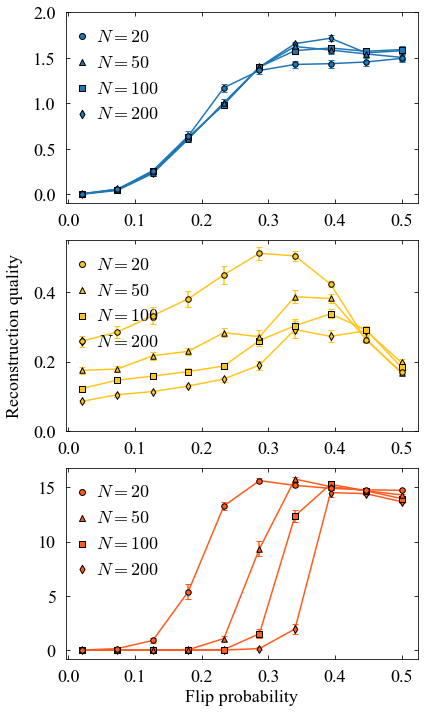

In [8]:
all_mode_means,all_clust_means,all_theta_means,all_mode_ent_means = [],[],[],[]
all_mode_errs,all_clust_errs,all_theta_errs,all_mode_ent_errs = [],[],[],[]
for a in range(4):
    recovery_results = eval('recovery_results'+str(a)+'.copy()')
    mode_means,clust_means,theta_means,mode_ent_means = [],[],[],[]
    mode_errs,clust_errs,theta_errs,mode_ent_errs = [],[],[],[]
    for res in recovery_results:
        mode_dists,clust_dists,theta_dists,mode_ents = res
        mode_means.append(np.mean(mode_dists))
        clust_means.append(np.mean(clust_dists))
        theta_means.append(np.mean(theta_dists))
        mode_ent_means.append(np.mean(mode_ents))
        mode_errs.append(np.std(mode_dists)/np.sqrt(len(mode_dists)))
        clust_errs.append(np.std(clust_dists)/np.sqrt(len(mode_dists)))
        theta_errs.append(np.std(theta_dists)/np.sqrt(len(mode_dists)))
        mode_ent_errs.append(np.std(mode_ents)/np.sqrt(len(mode_dists)))
    all_mode_means.append(mode_means)
    all_clust_means.append(clust_means)
    all_theta_means.append(theta_means)
    all_mode_ent_means.append(mode_ent_means)
    all_mode_errs.append(mode_errs)
    all_clust_errs.append(clust_errs)
    all_theta_errs.append(theta_errs)
    all_mode_ent_errs.append(mode_ent_errs)

plt.rcParams["mathtext.fontset"] = "cm"
fig,ax = plt.subplots(3,1,figsize=(6,10))
colors = ["#1F77B4", "#FFC51E", "#FF5B1E"]
    

markers = ['o','^','s','d']
for a in range(4):
    #ax[0].plot(flip_probs, all_clust_means[a], color=colors[0],zorder=-10-a)
    ax[0].errorbar(flip_probs, all_clust_means[a], all_clust_errs[a],capsize=3, color=colors[0],zorder=-10-a)
    ax[0].scatter(flip_probs, all_clust_means[a], color=colors[0],zorder=10-a,edgecolor='k',s=30,\
                 marker=markers[a])

    #ax[2].plot(flip_probs, all_mode_means[a], color=colors[2],zorder=-10-a)
    ax[2].errorbar(flip_probs, all_mode_means[a], all_mode_errs[a],capsize=3, color=colors[2],zorder=-10-a)
    ax[2].scatter(flip_probs, all_mode_means[a], color=colors[2],zorder=10-a,edgecolor='k',s=30,\
                 marker=markers[a])
    
    #ax[1].plot(flip_probs, all_theta_means[a], color=colors[1],zorder=-10-a)
    ax[1].errorbar(flip_probs, all_theta_means[a], all_theta_errs[a],capsize=3, color=colors[1],zorder=-10-a)
    ax[1].scatter(flip_probs, all_theta_means[a], color=colors[1],zorder=10-a,edgecolor='k',s=30,\
                 marker=markers[a])
    
ax[0].set_xticks([0.0,0.1,0.2,0.3,0.4,0.5])
ax[1].set_xticks([0.0,0.1,0.2,0.3,0.4,0.5])
ax[2].set_xticks([0.0,0.1,0.2,0.3,0.4,0.5])
ax[0].set_yticks([0.0,0.5,1.0,1.5,2.0])
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax[2].set_yticks([0,5,10,15,20])
ax[0].set_ylim([-0.1,2])
ax[1].set_ylim([0,0.55])
#ax[2].set_ylim([-0.5,15])

for a in range(3):
    ax[a].tick_params(direction='in',labelsize=18,which='major',pad=10,length=4)
    ax[a].tick_params(which='major',left=True, bottom=True,top=True,right=True, labelleft=True, labelbottom=True)

    labels = ax[a].get_xticklabels() + ax[a].get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    ax[a].scatter([],[], marker=markers[0], color=colors[a], edgecolors='k', label=r'$N=20$')
    ax[a].scatter([],[], marker=markers[1], color=colors[a], edgecolors='k', label=r'$N=50$')
    ax[a].scatter([],[], marker=markers[2], color=colors[a], edgecolors='k', label=r'$N=100$')
    ax[a].scatter([],[], marker=markers[3], color=colors[a], edgecolors='k', label=r'$N=200$')
    fontProperties = {'family':'Times New Roman', 'size' : 18}
    ax[a].legend(frameon=False, markerfirst=True, handlelength=0,prop=fontProperties)


fontProperties = {'family':'Times New Roman', 'size' : 18}
ax[2].set_xlabel('Flip probability',fontdict=fontProperties)
ax[1].set_ylabel(r'Reconstruction quality',fontdict=fontProperties,labelpad=10)
# ax[1].set_ylabel(r'Mode reconstruction quality',fontdict=fontProperties)
# ax[2].set_ylabel(r'Parameter reconstruction quality',fontdict=fontProperties)

plt.tight_layout()
plt.savefig('figs/recoveryGibbs.pdf')

Text(0.5, 0, 'Flip probability')

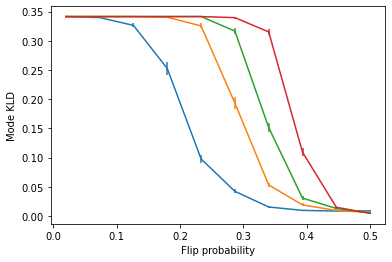

In [10]:
plt.errorbar(flip_probs,all_mode_ent_means[0],all_mode_ent_errs[0])
plt.errorbar(flip_probs,all_mode_ent_means[1],all_mode_ent_errs[1])
plt.errorbar(flip_probs,all_mode_ent_means[2],all_mode_ent_errs[2])
plt.errorbar(flip_probs,all_mode_ent_means[3],all_mode_ent_errs[3])
plt.ylabel('Mode KLD')
plt.xlabel('Flip probability')

# reality mining figure

In [ ]:
reality_networks_binned = []
for i in range(233):
    g = ig.load('networks/reality/binned/'+str(i)+'.gml')
    reality_networks_binned.append(g)

In [ ]:
# reses = Parallel(n_jobs=10)(delayed(gibbs_fast)(reality_networks_binned,\
#                         K = K,num_samples = 1000,n_restarts = 1,\
#                   alpha_guess = 0.99*np.ones(K),beta_guess = 0.001*np.ones(K),\
#                   pi_guess = np.ones(K)/K,rho_guess = 0.0000001,\
#                  labels_guess = None,beta_params = [1.,1.,1.,1.],\
#                  fix_labels = False,fix_theta = False) for K in range(1,16))

# with open('results/reality_binned_24hrs.pkl','wb') as f:
#     pickle.dump(reses,f)

with open('results/reality_binned_24hrs.pkl','rb') as f:
    reses = pickle.load(f)  

In [ ]:
modes,cluster_labels,thetas,logP = reses[np.argmax([r[-1] for r in reses])]
mode_nets = []
K = max(cluster_labels) + 1
for u in range(K):
    g = ig.Graph().Weighted_Adjacency(modes[u],mode='MAX',attr='weight',loops=False)
    g.vs['x'] = reality_networks_binned[0].vs['x']
    g.vs['y'] = reality_networks_binned[0].vs['y']
    mode_nets.append(g)

colors = ["#1F77B4","#FFC51E", "#FF5B1E",'#107C10','#B6B0FF','#A80000','#46ABB0','#00ACFC']
plt.rcParams["mathtext.fontset"] = "cm"

fig,ax = plt.subplots(figsize=(7,4))

clusts = [[t for t,l in enumerate(cluster_labels) if l == c] \
             for c in np.unique(cluster_labels)]
plt.plot(range(len(reality_networks_binned)),[g.ecount() for g in reality_networks_binned],c='k')
plt.scatter(range(len(reality_networks_binned)),[g.ecount() for g in reality_networks_binned],s=50,\
           c = [colors[cluster_labels[t]] for t in range(len(reality_networks_binned))],marker='o',
           zorder=10,edgecolors='k')

for c in range(K):
    plt.scatter([],[], marker='o', color=colors[c], edgecolors='k', label=r'Cluster '+str(c))
fontProperties = {'family':'Times New Roman', 'size' : 14}
plt.legend(frameon=False, markerfirst=True, handlelength=0,prop=fontProperties,ncol=2)

fontProperties = {'family':'Times New Roman', 'size' : 14}
plt.ylabel(r'number of edges in sample network',fontdict=fontProperties)
plt.xlabel('number of days into study',fontdict=fontProperties)

plt.yticks([0,100,200,300,400,500],fontname = "Times New Roman")
plt.xticks([25*i for i in range(10)],fontname = "Times New Roman")

ax.tick_params(direction='in',labelsize=14,which='major',pad=10,length=4)
ax.tick_params(which='major',left=True, bottom=True,top=True,right=True, labelleft=True, labelbottom=True)

plt.tight_layout()
plt.savefig('figs/reality_edgecounts.pdf')

In [ ]:
fig,ax = plt.subplots(figsize=(4,4.5))
ax.plot([r[-1] for r in reses][:10],linewidth=2,c='black')

fontProperties = {'family':'Times New Roman', 'size' : 16}
#plt.title(r'log posterior probability vs $K$',fontdict=fontProperties)
fontProperties = {'family':'Times New Roman', 'size' : 16}
plt.xlabel(r'$K$',fontdict=fontProperties)
plt.ylabel(r'average posterior log-probability ($\times 10^4$)',\
           fontdict=fontProperties,labelpad=0)

plt.yticks([-100000,-95000,-90000],\
           labels=[r'$-10.0$',r'$-9.5$',r'$-9.0$'],fontname = "Times New Roman")
plt.xticks(range(10),labels=range(1,11),fontname = "Times New Roman")

ax.tick_params(direction='in',labelsize=14,which='major',pad=10,length=4)
ax.tick_params(which='major',left=True, bottom=True,top=True,right=True, labelleft=True, labelbottom=True)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
[label.set_fontsize(16) for label in labels]

plt.axvline(2,linewidth=2,c='black',linestyle='--')

plt.tight_layout()

plt.savefig('figs/Kchoicereality.pdf')

In [ ]:
g_combined = ig.Graph(reality_networks_binned[0].vcount())
for g in reality_networks_binned:
    edges = [e.tuple for e in g.es]
    g_combined.add_edges(edges)
g_combined.simplify()    
g2 = pyg.igraph2gt(g_combined)
pos = sfdp_layout(g2, multilevel=True, cooling_step=0.99)
x, y = ungroup_vector_property(pos, [0, 1])
    
widths = [0.2,0.2,0.2]
for u in range(K):
    g = mode_nets[u].copy()    
    g.es['width'] = np.array(g.es['weight'])*
    g.vs['x'] = x.a #((np.array(list(x.a)) - np.mean(list(x.a)))/np.std(list(x.a)))
    g.vs['y'] = y.a #((np.array(list(y.a)) - np.mean(list(y.a)))/np.std(list(y.a)))
    g.es['color'] = ['black']*g.ecount()
    g.vs['color'] = colors[u]
        
    ig.plot(g,target='figs/realitymode'+str(u)+'.svg',vertex_size=10,bbox=(500,500))

In [ ]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
days_abbr = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
heights_arr = []
for u in range(K):
    heights = []
    for d in days:
        dayofweeks = [reality_networks_binned[i].vs[0]['dayofweek'] \
                      for i in range(233) if cluster_labels[i] == u]
        try:
            heights.append(Counter(dayofweeks)[d]/len(dayofweeks))
        except:
            heights.append(0)
    heights_arr.append(heights)

fig,ax = plt.subplots(1,2,figsize=(20,8),sharey=True)
x = np.arange(7)
w = 0.23
ax[0].bar(x-w, heights_arr[0], width=w, color=colors[0], align='center',edgecolor='k',tick_label=days_abbr)
ax[0].bar(x, heights_arr[1], width=w, color=colors[1], align='center',edgecolor='k',tick_label=days_abbr)
ax[0].bar(x+w, heights_arr[2], width=w, color=colors[2], align='center',edgecolor='k',tick_label=days_abbr)    
    

ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
ax[0].set_xticks(x)
ax[0].set_xticklabels(days_abbr)
ax[0].set_yticklabels([0,0.1,0.2,0.3,0.4])

ax[0].tick_params(direction='in',labelsize=14,which='major',pad=10,length=10)
ax[0].tick_params(which='major',left=True, bottom=True,top=True,right=True, labelleft=True, labelbottom=True)

labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
[label.set_fontsize(37) for label in labels]
fontProperties = {'family':'Times New Roman', 'size' : 35}
ax[0].set_ylabel(r'fraction of networks in cluster',fontdict=fontProperties)
ax[0].set_xlabel(r'day of sample network observation',fontdict=fontProperties,labelpad=10)
ax[1].set_xlabel(r'month of sample network observation',fontdict=fontProperties,labelpad=10)


months = ['September','October','November','December','January','February','March','April','May']
month_inds = ['09','10','11','12','01','02','03','04','05']
months_abbr = ['Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ind2month = dict(zip(month_inds,months))
heights_arr = []
for u in range(K):
    heights = []
    for m in months:
        monthofnets = [ind2month[reality_networks_binned[i].vs[0]['month']] \
                      for i in range(233) if cluster_labels[i] == u]
        try:
            heights.append(Counter(monthofnets)[m]/len(monthofnets))
        except:
            heights.append(0)
            
    heights_arr.append(heights)

x = np.arange(7,16)
ax[1].bar(x-w, heights_arr[0], width=w, color=colors[0], align='center',edgecolor='k',tick_label=months_abbr)
ax[1].bar(x, heights_arr[1], width=w, color=colors[1], align='center',edgecolor='k',tick_label=months_abbr)
ax[1].bar(x+w, heights_arr[2], width=w, color=colors[2], align='center',edgecolor='k',tick_label=months_abbr)    
    

ax[1].set_yticks([0,0.1,0.2,0.3,0.4])
ax[1].set_yticklabels([0,0.1,0.2,0.3,0.4])
ax[1].set_xticks(x)
ax[1].set_xticklabels(months_abbr)

ax[1].tick_params(direction='in',labelsize=14,which='major',pad=10,length=10)
ax[1].tick_params(which='major',left=True, bottom=True,top=True,right=True, labelleft=True, labelbottom=True)

labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
[label.set_fontsize(35) for label in labels]

for c in range(K):
    ax[0].scatter([],[], marker='o', color=colors[c], edgecolors='k', \
                  label=r'Cluster '+str(c),s=1000)
fontProperties = {'family':'Times New Roman', 'size' : 35}
ax[0].legend(frameon=False, markerfirst=True, handlelength=0,prop=fontProperties,ncol=1)

# for c in range(K):
#     plt.scatter([],[], marker='o', color=colors[c], edgecolors='k', label=r'Cluster '+str(c))
# fontProperties = {'family':'Times New Roman', 'size' : 14}
# plt.legend(frameon=False, markerfirst=True, handlelength=0,prop=fontProperties,ncol=1)

ax[0].set_ylim([0,0.38])
#plt.xlabel('day of sample',fontdict=fontProperties)
plt.tight_layout()
plt.savefig('figs/realityhists.pdf')

# brain networks figure

In [ ]:
brain_metadata_train = pd.read_csv('networks/brains/phenotypic_training.csv')
sub2sex_train = dict(zip(brain_metadata_train['Subj'].values,brain_metadata_train['Sex'].values))
sub2dx_train = dict(zip(brain_metadata_train['Subj'].values,brain_metadata_train['DX'].values))
brain_networks_train_aa,brain_networks_train_cc,brain_networks_train_ho = [],[],[]
for folder in glob.glob('networks/brains/Training/*'):
    aa_series = pd.read_csv(folder+'/timeseries_aal.csv',header=None)
    cc_series = pd.read_csv(folder+'/timeseries_cc200.csv',header=None)
    ho_series = pd.read_csv(folder+'/timeseries_ho.csv',header=None)
    sub = folder[-7:]
    for st in ['aa','cc','ho']:
        series = eval(st+'_series')
        corr = series.T.corr()
        percentile = 80
        threshold = 0.8#np.percentile(corr.values.flatten(),q=percentile)
        adj = corr > threshold
        g = ig.Graph().Adjacency(adj.values.astype("int"))
        g.vs['dx'] = sub2dx_train[sub]
        g.vs['sex'] = sub2sex_train[sub]
        g.simplify()
        exec('brain_networks_train_'+st+'.append(g)')
        
brain_metadata_test = pd.read_csv('networks/brains/phenotypic_validation.csv')
sub2sex_test = dict(zip(brain_metadata_test['Subj'].values,brain_metadata_test['Sex'].values))
sub2dx_test = dict(zip(brain_metadata_test['Subj'].values,brain_metadata_test['DX'].values))
brain_networks_test_aa,brain_networks_test_cc,brain_networks_test_ho = [],[],[]
for folder in glob.glob('networks/brains/Validation/*'):
    aa_series = pd.read_csv(folder+'/timeseries_aal.csv',header=None)
    cc_series = pd.read_csv(folder+'/timeseries_cc200.csv',header=None)
    ho_series = pd.read_csv(folder+'/timeseries_ho.csv',header=None)
    sub = folder[-7:]
    for st in ['aa','cc','ho']:
        series = eval(st+'_series')
        corr = series.T.corr()
        percentile = 80
        threshold = 0.8#np.percentile(corr.values.flatten(),q=percentile)
        adj = corr > threshold
        g = ig.Graph().Adjacency(adj.values.astype("int"))
        g.vs['dx'] = sub2dx_test[sub]
        g.vs['sex'] = sub2sex_test[sub]
        g.simplify()
        exec('brain_networks_test_'+st+'.append(g)')

In [ ]:
brain_networks_train_control = np.copy([g for g in brain_networks_train_aa if g.vs[0]['dx'] == 'Control'])
brain_networks_train_experimental = np.copy([g for g in brain_networks_train_aa if g.vs[0]['dx'] == 'ADHD'])
brain_networks_test = np.copy(brain_networks_test_aa)
mode_control,labels_control,theta_control,rho_control,lp_control = \
            gibbs_fast(brain_networks_train_control,K = 1,num_samples = 100,n_restarts = 1,\
                  alpha_guess = 0.7*np.ones(1),beta_guess = 0.3*np.ones(1),\
                  pi_guess = np.ones(1)/1,rho_guess = 0.1,
                 labels_guess = None,beta_params = [1.,1.,1.,1.,1.,1.],\
                 fix_labels = False,fix_theta = False)
mode_experimental,labels_experimental,theta_experimental,rho_experimental,lp_experimental = \
            gibbs_fast(brain_networks_train_experimental,K = 1,num_samples = 100,n_restarts = 1,\
                  alpha_guess = 0.7*np.ones(1),beta_guess = 0.3*np.ones(1),\
                  pi_guess = np.ones(1)/1,rho_guess = 0.1,
                 labels_guess = None,beta_params = [1.,1.,1.,1.,1.,1.],\
                 fix_labels = False,fix_theta = False)

mode0 = ig.Graph().Adjacency(mode_control[0]).as_undirected()
mode1 = ig.Graph().Adjacency(mode_experimental[0]).as_undirected()
train_modes = {0:{},1:{}}
for e in mode0.es:
    train_modes[0][tuple(sorted(e.tuple))] = 1
for e in mode1.es:
    train_modes[1][tuple(sorted(e.tuple))] = 1

res_supervised = gibbs_fast(brain_networks_test,K = 2,num_samples = 100,n_restarts = 1,\
                  alpha_guess = [theta_control[0],theta_experimental[0]],\
                  beta_guess = [theta_control[1],theta_experimental[1]],\
                  pi_guess = [0.5,0.5],rho_guess = (rho_control+rho_experimental)/2.,
                 labels_guess = None,beta_params = [1.,1.,1.,1.,1.,1.],\
                 fix_labels = False,fix_theta = True,fix_modes = train_modes)

# K = 2
# brain_networks = np.copy(brain_networks_test_aa)
# res_unsupervised = gibbs_fast(brain_networks,K = K,num_samples = 100,n_restarts = 1,\
#                   alpha_guess = 0.7*np.ones(K),beta_guess = 0.3*np.ones(K),\
#                   pi_guess = np.ones(K)/K,rho_guess = 0.1,
#                  labels_guess = None,beta_params = [1.,1.,1.,1.,1.,1.],\
#                  fix_labels = False,fix_theta = False)

In [ ]:
for u in range(2):
    print('Supervised, cluster',u,':',Counter([g.vs[0]['dx'] for ii,g in enumerate(brain_networks_test)\
                   if res_supervised[1][ii] == u]))
#     print('Unsupervised, cluster',u,':',Counter([g.vs[0]['dx'] for ii,g in enumerate(brain_networks)\
#                    if res_unsupervised[1][ii] == u]))

# MDS figure

In [ ]:
def hamming_matrix(edge_dicts):
    
    def hamming(ed1,ed2):
        false_positives = len(ed2)
        false_negatives = 0.
        for e in ed1.keys():
            try: 
                a = ed2[e]
                false_positives -= 1.
            except:
                false_negatives += 1.
        return false_positives + false_negatives
            
    N = len(edge_dicts)
    mat = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            mat[i,j] = hamming(edge_dicts[i],edge_dicts[j])
            mat[j,i] = mat[i,j]
            
    return mat

# mode1 = ig.Graph().Adjacency([[0,1,1,0,0,0,0,0],
#                [1,0,1,0,0,0,0,0],
#                [1,1,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0]]).as_undirected()
# mode2 = ig.Graph().Adjacency([[0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,1,1],
#                [0,0,0,0,0,1,0,1],
#                [0,0,0,0,0,1,1,0]]).as_undirected()
# mode3 = ig.Graph().Adjacency([[0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,1,0,0,0],
#                [0,0,0,1,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0]]).as_undirected()
# n = mode1.vcount()
# modes = [mode1,mode2,mode3]
# K = len(modes)
# alphas = 0.9*np.ones(K)
# betas = 0.1*np.ones(K)
# pis = np.ones(K)/K
# networks,true_labels = generate_synthetic(300,modes,alphas,betas,pis)
# edge_dicts = {}
# for t,g in enumerate(networks):
#     edge_dicts[t] = {}
#     for e in g.es:
#         edge_dicts[t][tuple(sorted(e.tuple))] = 1 
# mode_edicts = {}
# for u,g in enumerate(modes):
#     mode_edicts[u] = {}
#     for e in g.es:
#         mode_edicts[u][tuple(sorted(e.tuple))] = 1
        
# is_mode = []
# for t in range(len(networks)):
#     for u in range(K):
#         if np.sum(hamming_matrix([mode_edicts[u],edge_dicts[t]])) == 0:
#             is_mode.append(t)

# sns.set_style('ticks')

# colors = ["#1F77B4", "#FFC51E", "#FF5B1E"]

# hmat = hamming_matrix(edge_dicts)
# embedding = MDS(n_components=2,metric=True,dissimilarity='precomputed')
# X = embedding.fit_transform(hmat)
# with open('results/MDSpos.pkl','wb') as f:
#     pickle.dump(X,f)
    
with open('results/MDSpos.pkl','rb') as f:
    X = pickle.load(f)

x = X[:,0]
y = X[:,1]
xmin, xmax = min(x) - 1, max(x) + 1
ymin, ymax = min(y) - 1, max(y) + 1


    

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Reds')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
#ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'')
ax.set_ylabel(r'')
plt.xticks([])
plt.yticks([])

#plt.scatter(x,y,edgecolor='k',c='w')
# for p in is_mode:
#     plt.scatter([x[p]],[y[p]],edgecolor='k',c='w',zorder=10)
plt.scatter(x[40],y[40],edgecolor='k',c='w',zorder=10)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

plt.savefig('figs/MDS.pdf')